In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import math
from timefusion import TimeFusion, EarlyStopper
from torch import nn
from data import TimeFusionDataset
from torch.utils.data import DataLoader
from metrics import variogram_score, crps_sum

In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(10000):

    # Calculate underlying sine values
    y = 150*np.array([np.sin(i/20),np.sin((i/13))])
    #y = 1*np.array([np.sin(0.04*i),np.sin(0.04*i)])

    # Draw random samples from normal distribution
    z = np.random.multivariate_normal(z,cov)
    #z = np.array([0,0])

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

data.index = [pd.Timestamp('2000-01-01 00:00:00') + pd.DateOffset(hours=i) for i in range(len(data.index))]

# Remove 50% of samples to make into an irregular time-series
#keep = 0.20 # What fraction of cells to keep
keep = 0.8
mask = [False]*2*int(len(data)*keep) + [True]*2*(len(data) - int(len(data)*keep))
random.shuffle(mask)
mask = np.array(mask).reshape((-1,2))
data = data.mask(mask)

# Remove all rows without any data
#data = data.dropna(axis = 0, how = 'all')

#



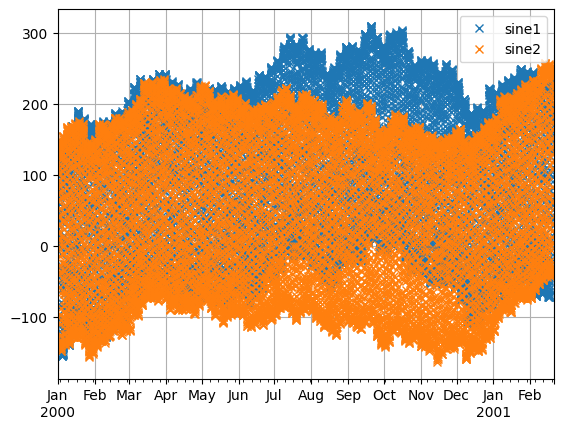

In [3]:
# Plot data so we can inspect it
data[:].plot(marker="x",linewidth=0)
plt.grid(True)

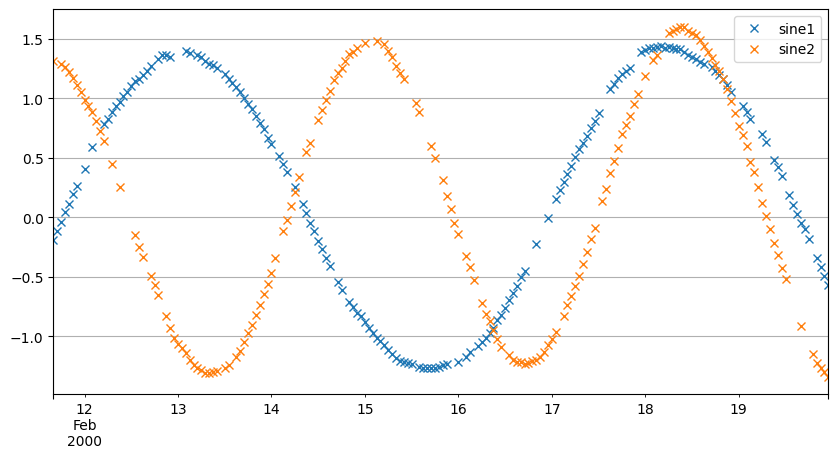

In [4]:
# Detrend data by subtracting running mean and dividing by running variance
#data - data.rolling(200).mean()
data -= data.rolling(100,min_periods=30).mean()
data /= data.rolling(200,min_periods=60).std()

#data = data.iloc[::5, :]

data = data[1000:]

# Replot data
data[:200].plot(marker='x',linewidth=0,figsize=[10,5])
plt.grid(True)

In [5]:
# Define some common variables
device = torch.device("cpu")
context_length = 50 
prediction_length = 30

encodings = [
    #lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24)),
    #lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*5)),
    #lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*10)),
    #lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24)),
    #lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*5)),
    #lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*10)),
]

# Create each dataset
train_data = TimeFusionDataset(
    data = data.iloc[:int(0.2*len(data))],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

val_data = TimeFusionDataset(
    data = data.iloc[int(0.95*len(data)):],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

train_loader = DataLoader(
    dataset = train_data,
    shuffle = True,
    num_workers = 0,
    batch_size = 64
)

val_loader = DataLoader(
    dataset = val_data,
    shuffle = True,
    num_workers = 0,
    batch_size = 64
)

In [6]:
for i, values in enumerate(train_loader, start = 1):
    tokens, mask = values
    if tokens.isnan().any():
        print(tokens.shape,i)


In [7]:
train_data.tensor_data.isnan().any()

tensor(False)

In [8]:
predictor = TimeFusion(
    context_length = context_length,
    prediction_length = prediction_length,
    timeseries_shape = (2,2), 
    num_encoder_layers=3,
    d_model=64,
    nhead=4,
    dim_feedforward=64,
    diff_steps=100,
    device = device,
    scaling=True
)

#predictor = torch.compile(predictor)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/diffusion.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [9]:
print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 101121


In [10]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

l = predictor.train_network(
    train_loader = train_loader,
    epochs=40,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=10)
)


 |==============================|  Batch: 27 / 27, Epoch: 1 / 40, Average Loss: 0.6892, Val MAE: 0.4605, val_loss: 0.4183


In [20]:
sample_index = 100

# timestamps = []
# for col in range(val_data.indices.shape[1]):
#     timestamps.append(list(val_data.data_copy.iloc[sample_index:,col].dropna().index[:predictor.prediction_length]))

#timestamps = np.array(timestamps)

samples = predictor.sample(
    data = val_data,
    #sample_indices = timestamps,
    sample_index = sample_index,
    num_samples = 100,
    timestamp_encodings = encodings
)

# realisations = []
# for col in range(val_data.indices.shape[1]):
#     realisations.append(val_data.data_copy.iloc[sample_index:,col].dropna()[:val_data.prediction_length])
# realisations = np.array(realisations)


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._transformer_encoder_layer_fwd(


In [21]:
# Get token for sample indices
token, _  = val_data[sample_index]

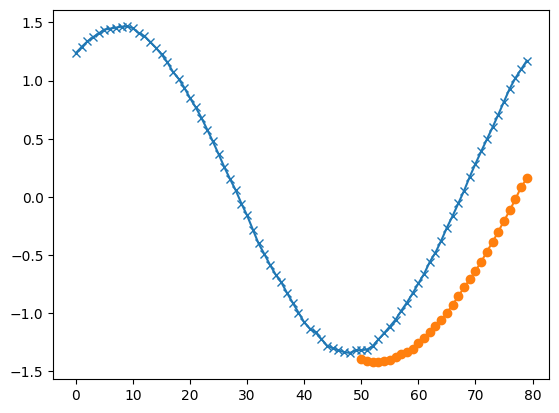

In [24]:
plt.plot(token[1,:,0],"-x")
plt.plot(list(range(50,80)),torch.mean(samples.cpu(),axis=0)[1],"-o")

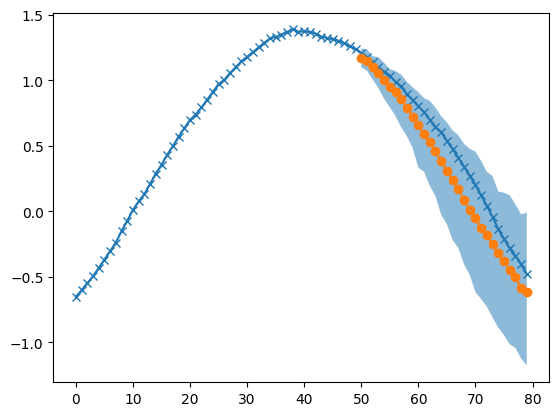

In [19]:
# Plot the samples
confidence = 0.1

samples_cpu = samples.cpu()
samples_cpu[:,0,:], _= torch.sort(samples_cpu[:,0,:],dim=0)
samples_cpu[:,1,:], _ = torch.sort(samples_cpu[:,1,:],dim=0)

plt.figure()
#plt.plot(list(range(50)),val_data.data_copy.iloc[:sample_index,0].dropna().iloc[-predictor.context_length:],"-x")
#plt.plot(list(range(30)),val_data.data_copy.iloc[sample_index:,0].dropna().iloc[:predictor.prediction_length],"-x")
plt.plot(token[0,:,0],"-x")
plt.fill_between(list(range(50,80)), samples_cpu[int(confidence*samples_cpu.shape[0]),0,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),0,:],alpha=0.5)
plt.plot(list(range(50,80)),torch.mean(samples.cpu(),axis=0)[0],"-o")

# plt.figure()
# plt.plot(val_data.data_copy.iloc[:sample_index,1].dropna().iloc[-predictor.context_length:],"-x")
# plt.plot(val_data.data_copy.iloc[sample_index:,1].dropna().iloc[:predictor.prediction_length],"-x")
# plt.fill_between(timestamps[1], samples_cpu[int(confidence*samples_cpu.shape[0]),1,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),1,:],alpha=0.5)
# plt.plot(timestamps[1],torch.mean(samples.cpu(),axis=0)[1],"-o")


In [ ]:
# Calculate metrics
var_score = variogram_score(realisations,np.array(samples.cpu()),**{"weights":"local","window_size":5})
crps_score = crps_sum(realisations,np.array(samples.cpu()))

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda y: (percentileofscore(F,y,kind="weak")/100 - np.heaviside(y - x, 1))**2, min(min(F),x), max(max(F),x),epsrel=1.49e-2,limit=100)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the

In [ ]:
print(var_score,crps_score)

2.008806443829886 0.03990441035140605


In [ ]:
for i, tokens in enumerate(train_loader, start = 1):
    #if self.device == torch.device("mps"):
    tokens = tokens.to(device)

    tok = torch.clone(tokens)

    # Scale data
    scale = torch.mean(tokens[:,:,:context_length,0],dim=2).view(tokens.shape[:2]+ tuple([1]))
    tokens[:,:,:,0] /= scale

    break

In [ ]:
tokens[0]

tensor([[[-4.6547e-01,  0.0000e+00],
         [-5.0019e-01,  0.0000e+00],
         [-4.7870e-01,  0.0000e+00],
         [-4.8079e-01,  0.0000e+00],
         [-4.3445e-01,  0.0000e+00],
         [-3.5295e-01,  0.0000e+00],
         [-2.9155e-01,  0.0000e+00],
         [-2.0261e-01,  0.0000e+00],
         [-7.6000e-02,  0.0000e+00],
         [ 4.9155e-02,  0.0000e+00],
         [ 2.1289e-01,  0.0000e+00],
         [ 3.8796e-01,  0.0000e+00],
         [ 5.8420e-01,  0.0000e+00],
         [ 7.7344e-01,  0.0000e+00],
         [ 9.4518e-01,  0.0000e+00],
         [ 1.1567e+00,  0.0000e+00],
         [ 1.3450e+00,  0.0000e+00],
         [ 1.4923e+00,  0.0000e+00],
         [ 1.6652e+00,  0.0000e+00],
         [ 1.8238e+00,  0.0000e+00],
         [ 2.0122e+00,  0.0000e+00],
         [ 2.1617e+00,  0.0000e+00],
         [ 2.2288e+00,  0.0000e+00],
         [ 2.3200e+00,  0.0000e+00],
         [ 2.4248e+00,  0.0000e+00],
         [ 2.4503e+00,  0.0000e+00],
         [ 2.4924e+00,  0.0000e+00],
 

In [ ]:
torch.maximum(tokens,torch.full(tokens.shape,1))

tensor([[[[ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          ...,
          [ 2.4377,  1.0000],
          [ 2.3981,  1.0000],
          [ 2.3508,  1.0000]],

         [[ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          [12.6637,  1.0000]]],


        [[[ 1.4679,  1.0000],
          [ 1.3084,  1.0000],
          [ 1.1573,  1.0000],
          ...,
          [ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          [ 1.1995,  1.0000]],

         [[ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          [ 1.0000,  1.0000],
          ...,
          [ 5.1786,  1.0000],
          [23.2728,  1.0000],
          [ 1.0000,  1.0000]]],


        [[[ 1.5832,  1.0000],
          [ 1.4606,  1.0000],
          [ 1.2960,  1.0000],
          ...,
          [ 1.0000,  1.0000],
          [ 1.0410,  1.0000],
          [ 1.1531,  1.0000]],

         [[

In [ ]:
torch.max(scale,1)

torch.return_types.max(
values=tensor([[14.9267],
        [ 0.9517],
        [ 1.0707],
        [ 1.1517],
        [ 1.1698],
        [ 1.1819],
        [15.3147],
        [ 0.8130],
        [ 1.0276],
        [ 1.0804],
        [ 1.1582],
        [ 1.1211],
        [ 1.2459],
        [ 1.5178],
        [ 1.1473],
        [ 0.9649],
        [ 1.1838],
        [ 0.9012],
        [ 1.1334],
        [ 1.2532],
        [ 0.8755],
        [ 1.0749],
        [ 1.1827],
        [ 1.3029],
        [15.9318],
        [46.8159],
        [ 1.0576],
        [ 1.2272],
        [ 0.8081],
        [ 0.9451],
        [ 1.1099],
        [ 1.1639],
        [ 1.0281],
        [ 1.2278],
        [ 1.1641],
        [ 1.1322],
        [ 0.9057],
        [37.6330],
        [ 1.0545],
        [ 1.1925],
        [ 0.8297],
        [ 1.1200],
        [ 0.9271],
        [ 1.1091],
        [ 1.0196],
        [ 1.2563],
        [ 1.1456],
        [ 1.4339],
        [ 1.2264],
        [12.3134],
        [16.5225],
